In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
%config InlineBackend.figure_format='retina'

sns.set(
        font_scale = 1.5,
        style = 'whitegrid',
        rc = {'figure.figsize' : (20,7)}
        )

### Сначала загрузим данные и немного отформатируем

In [2]:
def parse_col(df): ## функция для преобразования заголовок колонок из исходной эксель-таблицы
    ## в параметр header при чтении xls-файла нужно передать список из двух заголовков пример -> header=[0,1]
    df['авиабилеты'] = df['авиабилеты'].astype('float64')

    h1 = [i[0] for i in df.columns] ## выделяю список из первых частей заголовка
    h2 = pd.Series([np.nan if 'Unnamed:' in i[1] 
                            else i[1].replace(' ','_') 
                            for i in df.columns])\
            .fillna(method='ffill') ## и аналогично вторая часть

    df.columns = pd.MultiIndex.from_tuples(zip(h1,h2), names=['category','type'])


In [3]:
df_days = pd.read_excel('dynamics.xlsx', sheet_name='по дням', 
                        header=[0,1], 
                        skiprows=lambda x: x in [0,1], 
                        parse_dates=[1]
                       )
parse_col(df_days)

df_weeks = pd.read_excel('dynamics.xlsx',
                         sheet_name='по неделям',
                         header=[0,1],
                         skiprows=lambda x: x in [0,1],
                         parse_dates=[1],
                         index_col=0
                        )
parse_col(df_weeks)


df_month = pd.read_excel('dynamics.xlsx',
                         sheet_name='по месяцам',
                         header=[0,1],
                         parse_dates=[1]
                        )
parse_col(df_month)

## Задача 0
* Найти категорию трат, где по дням был максимальный разброс значений «сумм транзакций» (значения из таблиц)
* Найти категорию трат, где в течение года по дням был максимальный разброс значений «количества транзакций» (значения из таблиц)

Визуализируйте свои выводы в удобном для понимания формате.

#### 0.1 Для начала найдем категорию трат, где по дням был максимальный разброс значений «сумма транзакций» (значения из таблиц)
> В качестве метрики для оценки разброса использую разность между максимальным и минимальным значениями по дням для каждой категории

In [4]:
days_expence = df_days.unstack().unstack().reset_index()\
                .query('type == "сумма_трат"')\
                .drop('type', axis=1)\
                .set_index('category')\
                .astype('float64')
days_expence.head()

,0,1,2,3,4,5,6,7,8,9,...,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399
category,,,,,,,,,,,,,,,,,,,,,
авиабилеты,0.010231,0.012811,0.013293,0.014658,0.012856,0.011632,0.013593,0.014205,0.019086,0.023008,...,0.009599,0.009739,0.012124,0.014069,0.015108,0.014071,0.013206,0.008711,0.008225,0.012762
автосервис,0.000343,0.002439,0.006182,0.008501,0.008745,0.007164,0.005217,0.010344,0.011120,0.011194,...,0.017154,0.013600,0.015278,0.016051,0.017297,0.016562,0.016844,0.017328,0.014515,0.018421
аптеки,0.003922,0.008208,0.008876,0.009292,0.009389,0.008873,0.007813,0.009561,0.011452,0.011518,...,0.010037,0.008984,0.011365,0.011627,0.011570,0.011212,0.011356,0.010112,0.009037,0.011662
бары,0.002554,0.002381,0.002737,0.002677,0.002896,0.002732,0.002162,0.001598,0.000967,0.001132,...,0.002811,0.001957,0.000736,0.000816,0.000943,0.001037,0.001957,0.003045,0.002262,0.000777
"дом, ремонт",0.005662,0.026357,0.033407,0.036214,0.037037,0.035364,0.029709,0.036491,0.028672,0.028718,...,0.041193,0.036275,0.033932,0.033858,0.034223,0.033283,0.034180,0.041257,0.036695,0.036021


In [5]:
days_expence['expance_span_by_days'] = days_expence.max(axis=1) - days_expence.min(axis=1)
px.line(data_frame=days_expence.expance_span_by_days.sort_values( ascending=False))

#### Вывод:
> В соответствии с графиком наибольшим разбросом трат относительно суммы транзакций обладает категория - другое, но поскольку это суммарная характеристика, то в действительности именно категория сумермаркеты обладает наибольшим разбросом

#### 0.2 Найти категорию трат, где в течение года по дням был максимальный разброс значений «количества транзакций» (значения из таблиц)
> Группирую по годам и нахожу наибольшую разницу между количеством транзакций для каждой категории

In [6]:
df_days['year'] = df_days[('категория','день')].dt.year
df_days.set_index('year', inplace=True)
df_days.drop(labels=[('категория','день')], axis=1)
transact_by_days = df_days.loc[:, (slice(None),'количество_транзакций')]  ##slice при работе с мультииндексами
transact_by_days

category,авиабилеты,автосервис,аптеки,бары,"дом, ремонт",доставка еды,другое,ж/д билеты,зоомагазины,"кафе, рестораны",...,"обувь, одежда",отели,развлечения,супермаркеты,театры,топливо,транспорт,туры,фастфуд,фитнес
type,количество_транзакций,количество_транзакций,количество_транзакций,количество_транзакций,количество_транзакций,количество_транзакций,количество_транзакций,количество_транзакций,количество_транзакций,количество_транзакций,...,количество_транзакций,количество_транзакций,количество_транзакций,количество_транзакций,количество_транзакций,количество_транзакций,количество_транзакций,количество_транзакций,количество_транзакций,количество_транзакций
year,,,,,,,,,,,,,,,,,,,,,
2019,0.001088,0.000337,0.008916,0.003098,0.001664,0.000107,0.044354,0.001455,0.000102,0.013102,...,0.003179,0.001892,0.002652,0.100576,0.001326,0.010807,0.038910,0.000254,0.021257,0.000576
2019,0.001428,0.001705,0.017155,0.002948,0.009072,0.000153,0.065048,0.001880,0.001271,0.019697,...,0.014238,0.002617,0.004189,0.164191,0.001735,0.018787,0.039801,0.000371,0.038561,0.001489
2019,0.001493,0.003497,0.018198,0.003213,0.012143,0.000188,0.071994,0.001871,0.001754,0.022746,...,0.016319,0.002758,0.004402,0.182400,0.001511,0.020850,0.039899,0.000408,0.045178,0.001763
2019,0.001548,0.004344,0.018809,0.003128,0.013372,0.000174,0.074367,0.001881,0.001817,0.023561,...,0.016885,0.002612,0.004281,0.193147,0.001437,0.021749,0.042616,0.000412,0.047430,0.001886
2019,0.001403,0.004306,0.018697,0.003569,0.013681,0.000195,0.074326,0.001693,0.001905,0.024098,...,0.016741,0.002572,0.004151,0.200681,0.001291,0.022745,0.042777,0.000413,0.048249,0.001849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022,0.001259,0.007474,0.020432,0.001584,0.013441,0.000513,0.116602,0.002131,0.002178,0.015722,...,0.011075,0.000809,0.004721,0.342299,0.000896,0.022280,0.121748,0.001306,0.107247,0.001500
2022,0.001213,0.007957,0.020616,0.002868,0.013910,0.000652,0.122272,0.002066,0.002299,0.017904,...,0.011683,0.000895,0.005265,0.372497,0.001081,0.024624,0.129427,0.001341,0.115433,0.001606


In [7]:
transact_diff = transact_by_days.groupby('year')\
                                .agg(func=lambda x: x.max()-x.min())
transact_diff

category,авиабилеты,автосервис,аптеки,бары,"дом, ремонт",доставка еды,другое,ж/д билеты,зоомагазины,"кафе, рестораны",...,"обувь, одежда",отели,развлечения,супермаркеты,театры,топливо,транспорт,туры,фастфуд,фитнес
type,количество_транзакций,количество_транзакций,количество_транзакций,количество_транзакций,количество_транзакций,количество_транзакций,количество_транзакций,количество_транзакций,количество_транзакций,количество_транзакций,...,количество_транзакций,количество_транзакций,количество_транзакций,количество_транзакций,количество_транзакций,количество_транзакций,количество_транзакций,количество_транзакций,количество_транзакций,количество_транзакций
year,,,,,,,,,,,,,,,,,,,,,
2019,0.002787,0.007980,0.015278,0.003779,0.022060,0.000359,0.095439,0.001493,0.003125,0.023171,...,0.026581,0.001490,0.002750,0.232947,0.001663,0.019807,0.056653,0.000443,0.083845,0.001601
2020,0.003139,0.008160,0.023771,0.004941,0.026359,0.000661,0.096745,0.002083,0.003926,0.029054,...,0.026591,0.003131,0.004390,0.267032,0.001872,0.020781,0.085279,0.000539,0.093844,0.002421
2021,0.002082,0.010055,0.016372,0.003951,0.026369,0.000667,0.103785,0.001382,0.004031,0.019891,...,0.028640,0.001410,0.011305,0.289222,0.001023,0.021563,0.066430,0.001280,0.094988,0.002356
2022,0.001696,0.009502,0.019268,0.003740,0.017097,0.000614,0.077249,0.001401,0.003230,0.012257,...,0.025292,0.001557,0.010141,0.251691,0.001204,0.019609,0.067159,0.001477,0.083119,0.002036


In [8]:
res_transact_diff = transact_diff.unstack().unstack()\
                                .reset_index()\
                                .drop(labels='type', axis=1)\
                                .set_index('category')
res_transact_diff['max_transact_span'] = res_transact_diff.max(axis=1)
res_transact_diff



year,2019,2020,2021,2022,max_transact_span
category,,,,,
авиабилеты,0.002787,0.003139,0.002082,0.001696,0.003139
автосервис,0.007980,0.008160,0.010055,0.009502,0.010055
аптеки,0.015278,0.023771,0.016372,0.019268,0.023771
бары,0.003779,0.004941,0.003951,0.003740,0.004941
"дом, ремонт",0.022060,0.026359,0.026369,0.017097,0.026369
доставка еды,0.000359,0.000661,0.000667,0.000614,0.000667
другое,0.095439,0.096745,0.103785,0.077249,0.103785
ж/д билеты,0.001493,0.002083,0.001382,0.001401,0.002083
зоомагазины,0.003125,0.003926,0.004031,0.003230,0.004031


In [9]:
px.line(data_frame=res_transact_diff.sort_values('max_transact_span', ascending=False), y='max_transact_span')

### Вывод:
> В соответствии с графиком наибольшим разбросом относительно колличества транзакций обладают супермаркеты, можно предположить, что это связано праздниками. Поскольку в канун праздников - большие траты и соответственно большое количество транзакций, на следующий день после праздника - количество транзакций сильно меньше. И именно с этим связаны большие различия относительно трат


> Также можно объяснить с чем связаны минимумы на графике:
> * доставка - нет никаких трудностей, даже праздники не сильно повлияют на заказы
> * жд/авиабилеты, зоомагазины, театры - их берут заранее и цена +- одинаковая
> * потребность в тратах на обувь и одежду существует всегда, хотя такие категории имеют сезонный характер


## Задача 1
Найти категории трат в разбивке по неделям, между количеством транзакций которых была наибольшая корреляция  

Результат предоставьте в формате графика, отражающего общие корреляции всех категорий по неделям (график данного типа изучали на лекции)  

По графику сделайте 3 вывода относительно корреляций категорий   

**Например:** покупка авиабилетов коррелирует с покупкой в супермаркетах, потому что… (тут делаем предположения почему так может быть)

In [10]:
transact_week = df_weeks.loc[:, (slice(None),'количество_транзакций')]
transact_week.columns = transact_week.columns.droplevel(1)

transact_week

category,авиабилеты,автосервис,аптеки,бары,"дом, ремонт",доставка еды,другое,ж/д билеты,зоомагазины,"кафе, рестораны",...,"обувь, одежда",отели,развлечения,супермаркеты,театры,топливо,транспорт,туры,фастфуд,фитнес
2019-01-07,0.002119,0.005434,0.023342,0.002731,0.014735,0.000258,0.093792,0.001806,0.002498,0.027156,...,0.017056,0.002063,0.003492,0.250587,0.001041,0.025449,0.055804,0.000429,0.065092,0.001928
2019-01-14,0.002415,0.005470,0.023736,0.002551,0.014176,0.000294,0.098289,0.001982,0.002512,0.031117,...,0.015813,0.001940,0.002803,0.258885,0.001013,0.025118,0.061373,0.000429,0.078432,0.001948
2019-01-21,0.002423,0.005651,0.024683,0.002645,0.014426,0.000305,0.097326,0.002064,0.002532,0.031768,...,0.015491,0.001986,0.002684,0.264124,0.001028,0.026379,0.063700,0.000440,0.079174,0.001858
2019-01-28,0.002787,0.005435,0.025740,0.002831,0.014450,0.000308,0.098396,0.002113,0.002581,0.032082,...,0.015261,0.002057,0.002877,0.267871,0.001096,0.025854,0.064546,0.000467,0.079068,0.002007
2019-02-04,0.002548,0.005657,0.026044,0.002980,0.014475,0.000312,0.097535,0.002219,0.002586,0.032253,...,0.015033,0.002148,0.003124,0.271323,0.001118,0.026257,0.066548,0.000471,0.080053,0.001904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,0.001346,0.007546,0.024419,0.002528,0.015953,0.000585,0.132845,0.002254,0.002702,0.018489,...,0.013594,0.001118,0.007144,0.399218,0.000780,0.026619,0.134213,0.001793,0.115993,0.001603
2022-10-03,0.001326,0.007969,0.023134,0.002529,0.016280,0.000587,0.132106,0.002169,0.002658,0.017956,...,0.012682,0.001012,0.006991,0.398539,0.000924,0.025719,0.131874,0.001543,0.115869,0.001633
2022-10-10,0.001330,0.008551,0.023880,0.002666,0.017199,0.000627,0.137996,0.002282,0.002813,0.018591,...,0.013958,0.001040,0.007191,0.410322,0.001006,0.026314,0.133401,0.001507,0.120756,0.001734
2022-10-17,0.001308,0.008706,0.023711,0.002601,0.016857,0.000623,0.136554,0.002244,0.002709,0.018126,...,0.013978,0.000978,0.006392,0.403804,0.001035,0.026043,0.133599,0.001446,0.119382,0.001762


<AxesSubplot:xlabel='category', ylabel='category'>

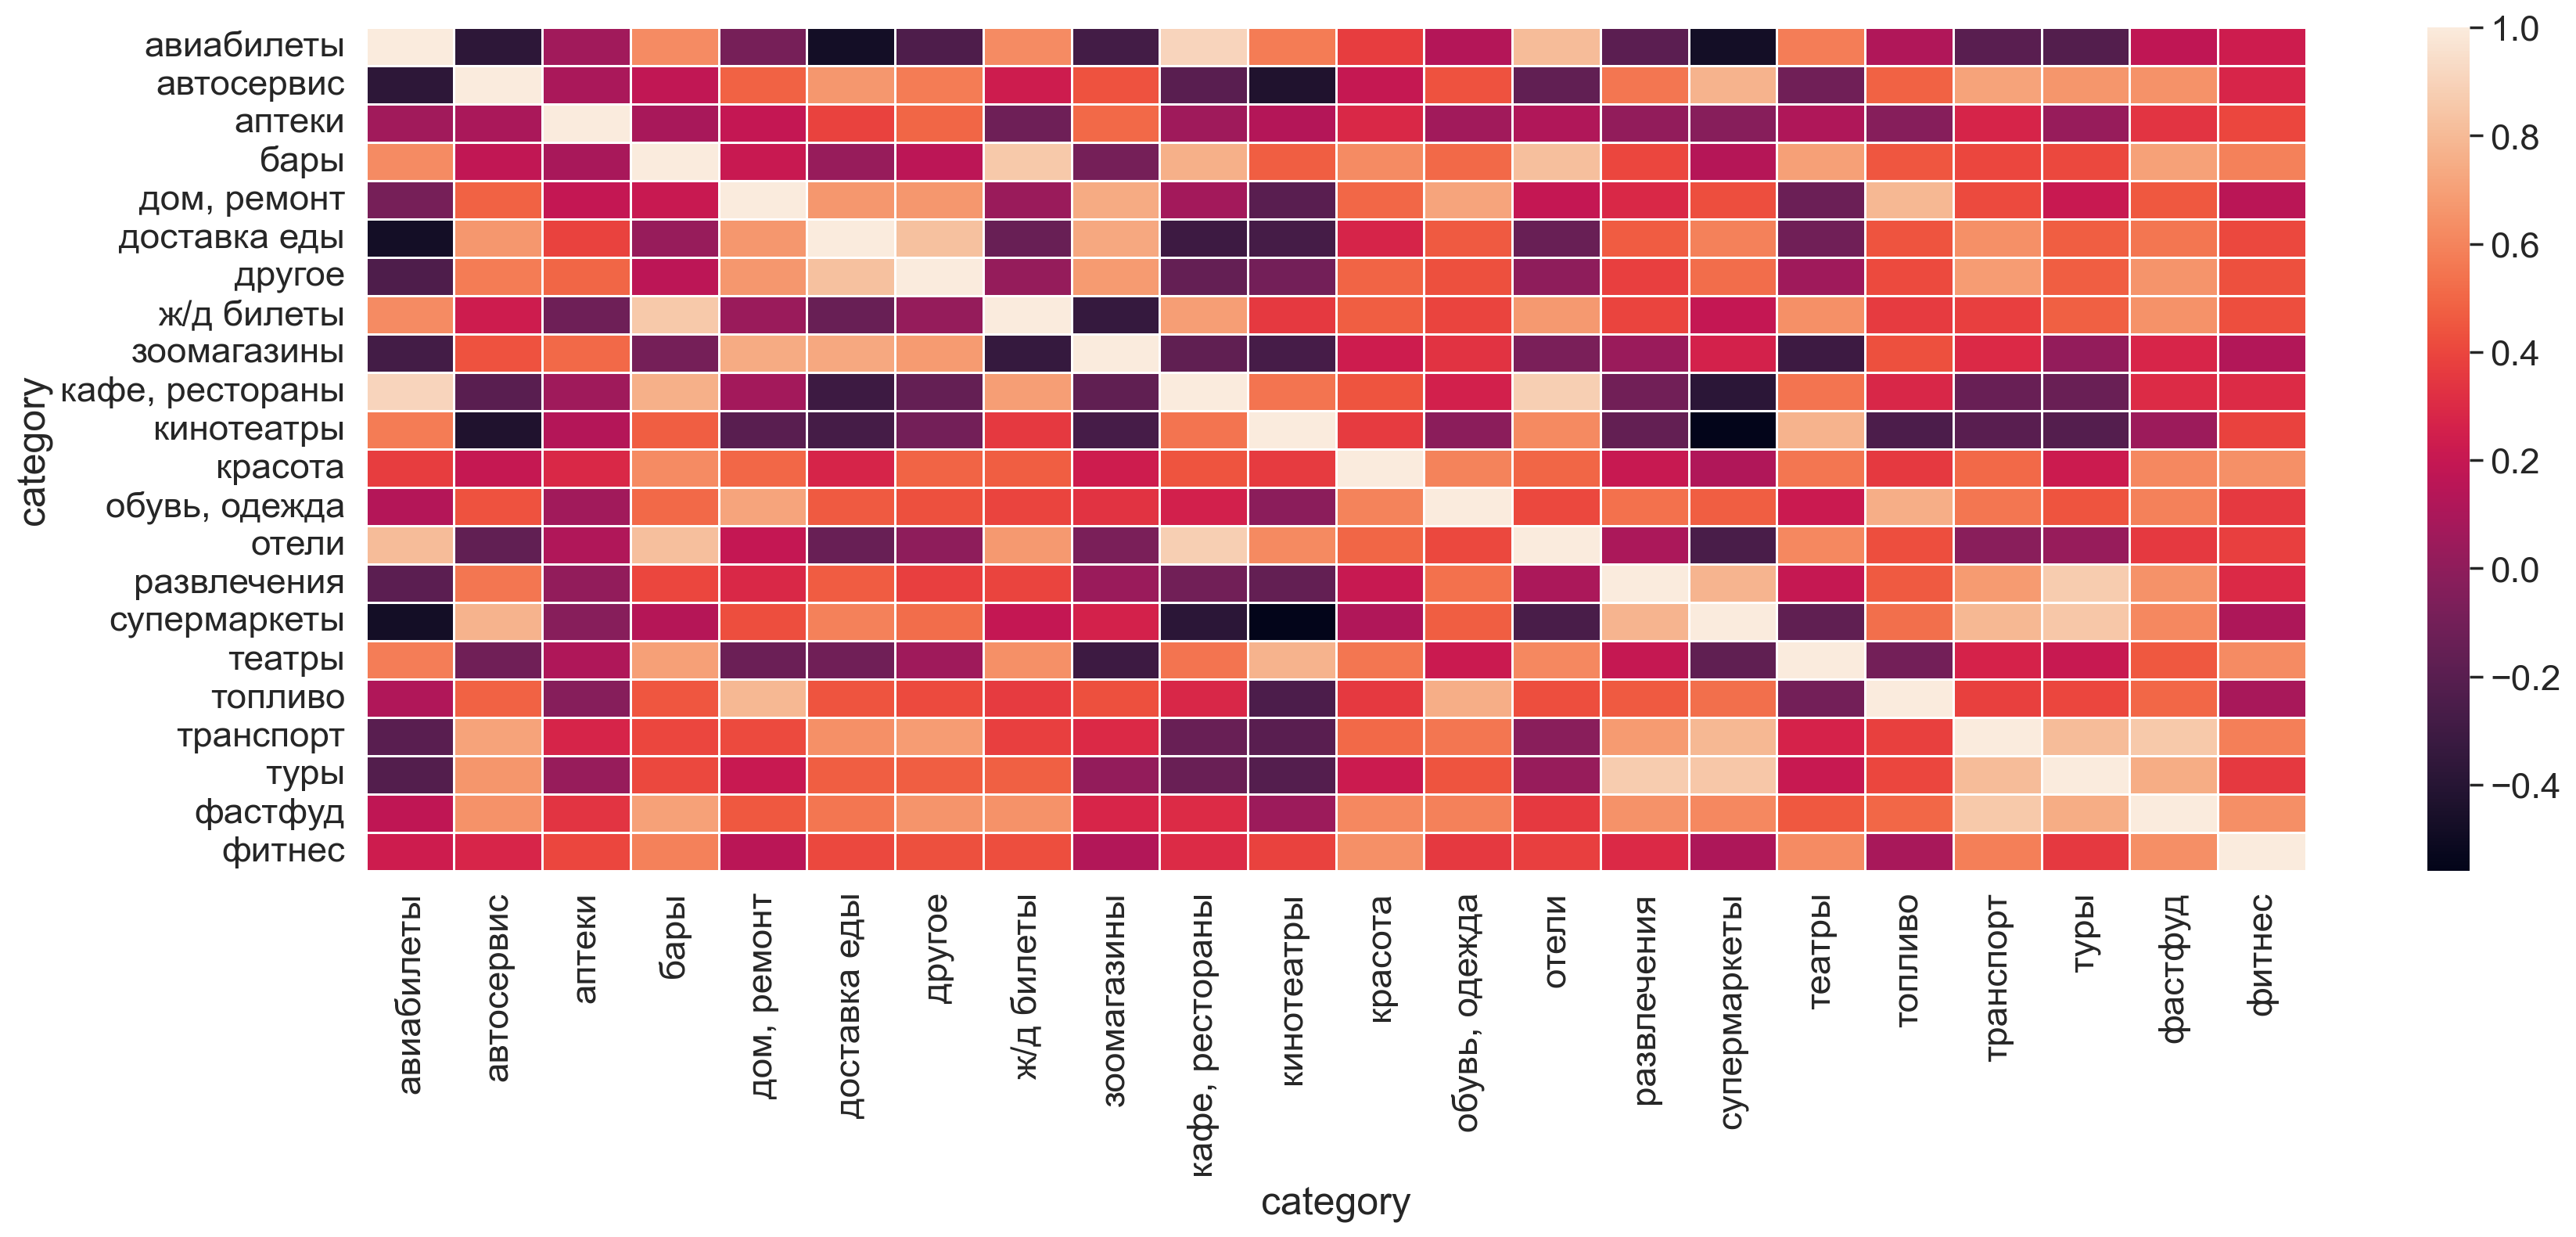

In [11]:
sns.heatmap(transact_week.corr(), linewidths=0.5)

 #### По графику хорошо видны категории с положительной корреляцией:
* <b>авиабилеты - отели</b>, если это случай либо отдыха либо командировки, что является вполне естественным
* <b>авиабилеты - кафе/рестораны</b>, что довольно распространено в эропортах, например во время ожидания своего вылета
* <b>развлечения - туры</b>, так как тур связан с отпуском/выходными/праздниками, поэтому человек позволяет себе потратиться на развлечения и различные экскурсии 
* <b>кафе/рестораны - отели</b>

## Задача 2
Проверьте, как отразились на покупках в различных категориях следующие события:
* Принятие коронавирусных мер
* Праздники
* Сезонность

Для этого проверьте следующие гипотезы:
* Количество транзакций в барах/кафе и ресторанах/отелях после принятия коронавирусных мер уменьшилось
* В предновогодний период средний чек вырос
* Весной траты в категории фитнес растут

#### Сперва проверим как уменьшилось количесттво транзакций в барах/кафе и ресторанах/отелях после принятия коронавирусных мер

In [12]:
df_month.set_index([('категория','месяц')], inplace=True)

In [13]:
tr_mont = df_month.loc[:, (slice(None), ['type','количество_транзакций'])]
tr_mont.columns = tr_mont.columns.droplevel(1)

/var/folders/wk/f7xb8jbs2f95g5mv_2cpn6hh0000gn/T/ipykernel_80994/235790423.py:1: FutureWarning:

The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`



In [14]:
tr_pub_cafe_hotel = tr_mont[['бары','кафе, рестораны','отели']]
tr_pub_cafe_hotel.index.rename('month', inplace=True)
tr_pub_cafe_hotel.head()

category,бары,"кафе, рестораны",отели
month,,,
2019-01-01,0.002817,0.029924,0.002213
2019-02-01,0.002814,0.030400,0.002056
2019-03-01,0.003292,0.033217,0.002315
2019-04-01,0.003151,0.033923,0.002346
2019-05-01,0.003516,0.034656,0.002523


In [15]:
x_cov_start = pd.to_datetime('2020-03-01')
x_cov_react = pd.to_datetime('2020-04-01')

In [16]:
fig1 = px.line(data_frame=tr_pub_cafe_hotel)
fig1.add_vline(x=x_cov_start, line_dash='dash', line_color='red')
fig1.add_vline(x=x_cov_react, line_dash='dash', line_color='orange')

#### Уже за месяц Covid-19 довольно сильно повлиял на количество транзакций по категориям:
- кафе/рестораны
- бары
- отели

#### Теперь рассмотрим насколько возрастает средний чек в предновогодний период

In [17]:
cheque = df_days.reset_index()\
        .drop(columns=['year'], index=1)\
        .loc[:,(slice(None),['день','средний_чек'])]
cheque.columns = cheque.columns.droplevel(1)
cheque.rename(columns={'категория':'date'}, inplace=True)
cheque.head()

/var/folders/wk/f7xb8jbs2f95g5mv_2cpn6hh0000gn/T/ipykernel_80994/1286574267.py:1: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



category,date,авиабилеты,автосервис,аптеки,бары,"дом, ремонт",доставка еды,другое,ж/д билеты,зоомагазины,...,"обувь, одежда",отели,развлечения,супермаркеты,театры,топливо,транспорт,туры,фастфуд,фитнес
0,2019-01-01,11399.071102,1235.336931,533.112383,999.333513,4124.509235,1225.740431,1410.320490,2596.226457,1283.881179,...,3571.786182,7379.008285,1565.656964,534.712369,2056.440760,1072.265434,321.496274,9382.603938,574.646502,1749.684460
2,2019-01-03,10791.392744,2142.467039,591.103482,1032.163795,3333.948962,1137.866905,1932.796604,2616.347101,928.519882,...,3508.119952,7668.635603,1629.456501,587.236768,2173.343989,1133.467552,301.906521,9596.168458,532.152586,1931.075823
3,2019-01-04,11476.564111,2371.758174,598.658270,1036.854424,3282.052356,1260.821294,1954.891151,2563.759111,915.355889,...,3507.464290,6951.066888,1659.407663,597.582976,2196.725825,1142.625344,288.072549,10762.061134,526.666040,1898.765747
4,2019-01-05,11101.994139,2461.109026,608.553209,983.346705,3280.778720,1301.049275,1940.806702,2475.230279,862.878566,...,3537.461768,6867.597705,1622.228587,611.411951,2249.082773,1140.087413,286.418166,11604.758873,525.693799,1844.312659
5,2019-01-06,10227.909701,2142.135056,591.363709,965.389557,3254.110083,1219.828806,1832.905193,2364.712937,869.059649,...,3329.516846,7030.919328,1711.118766,616.440079,2113.823719,1142.526091,272.029136,11162.972029,525.156386,1829.528249


In [18]:
ny_2020 = cheque.query('date>="2019-12-20" and date<="2020-01-07"')\
				.set_index('date') ## рассмотрим только +- неделю
ny_2020.head()

category,авиабилеты,автосервис,аптеки,бары,"дом, ремонт",доставка еды,другое,ж/д билеты,зоомагазины,"кафе, рестораны",...,"обувь, одежда",отели,развлечения,супермаркеты,театры,топливо,транспорт,туры,фастфуд,фитнес
date,,,,,,,,,,,,,,,,,,,,,
2019-12-20,12372.810144,3099.949195,673.727219,891.906996,3303.691295,940.379190,1819.123884,2353.539862,1001.001268,851.753305,...,3095.122950,7050.487753,1340.094029,579.191550,3824.939359,1094.499638,217.207006,14765.049905,353.293046,2785.388962
2019-12-21,12442.030518,3296.933895,634.171038,931.984748,3494.064592,998.787920,1820.448503,2338.068404,996.116229,1209.240480,...,3137.103005,6897.883558,1249.804746,686.136802,2825.683308,1133.745157,243.282496,11674.777481,474.906903,2360.986437
2019-12-22,12791.378887,3116.381365,608.544383,880.097213,3379.182662,1193.676757,1758.883829,2518.694074,940.681279,1124.284214,...,3075.422979,6889.324138,1302.778888,660.374100,2831.175813,1133.848672,231.094091,11173.647538,459.818873,2364.352698
2019-12-23,12900.226676,3022.227958,655.986678,844.371177,3293.943031,964.645027,1899.986667,2315.147583,1035.287769,664.787268,...,2944.127322,7601.599081,1455.665729,540.302169,3753.125329,1090.182167,213.846456,14998.707582,307.745425,2872.779139
2019-12-24,12626.846864,3210.252565,665.880472,845.321000,3398.186989,1056.634132,1882.929227,2248.304247,1078.663692,726.325052,...,2929.523915,7417.421375,1548.170280,562.273651,3603.175112,1108.384965,200.909887,14635.267411,311.975956,3135.833752


In [19]:
px.line(data_frame=ny_2020,
		 log_y=True,
		 line_shape='spline',#linear or spline
		 height=700)

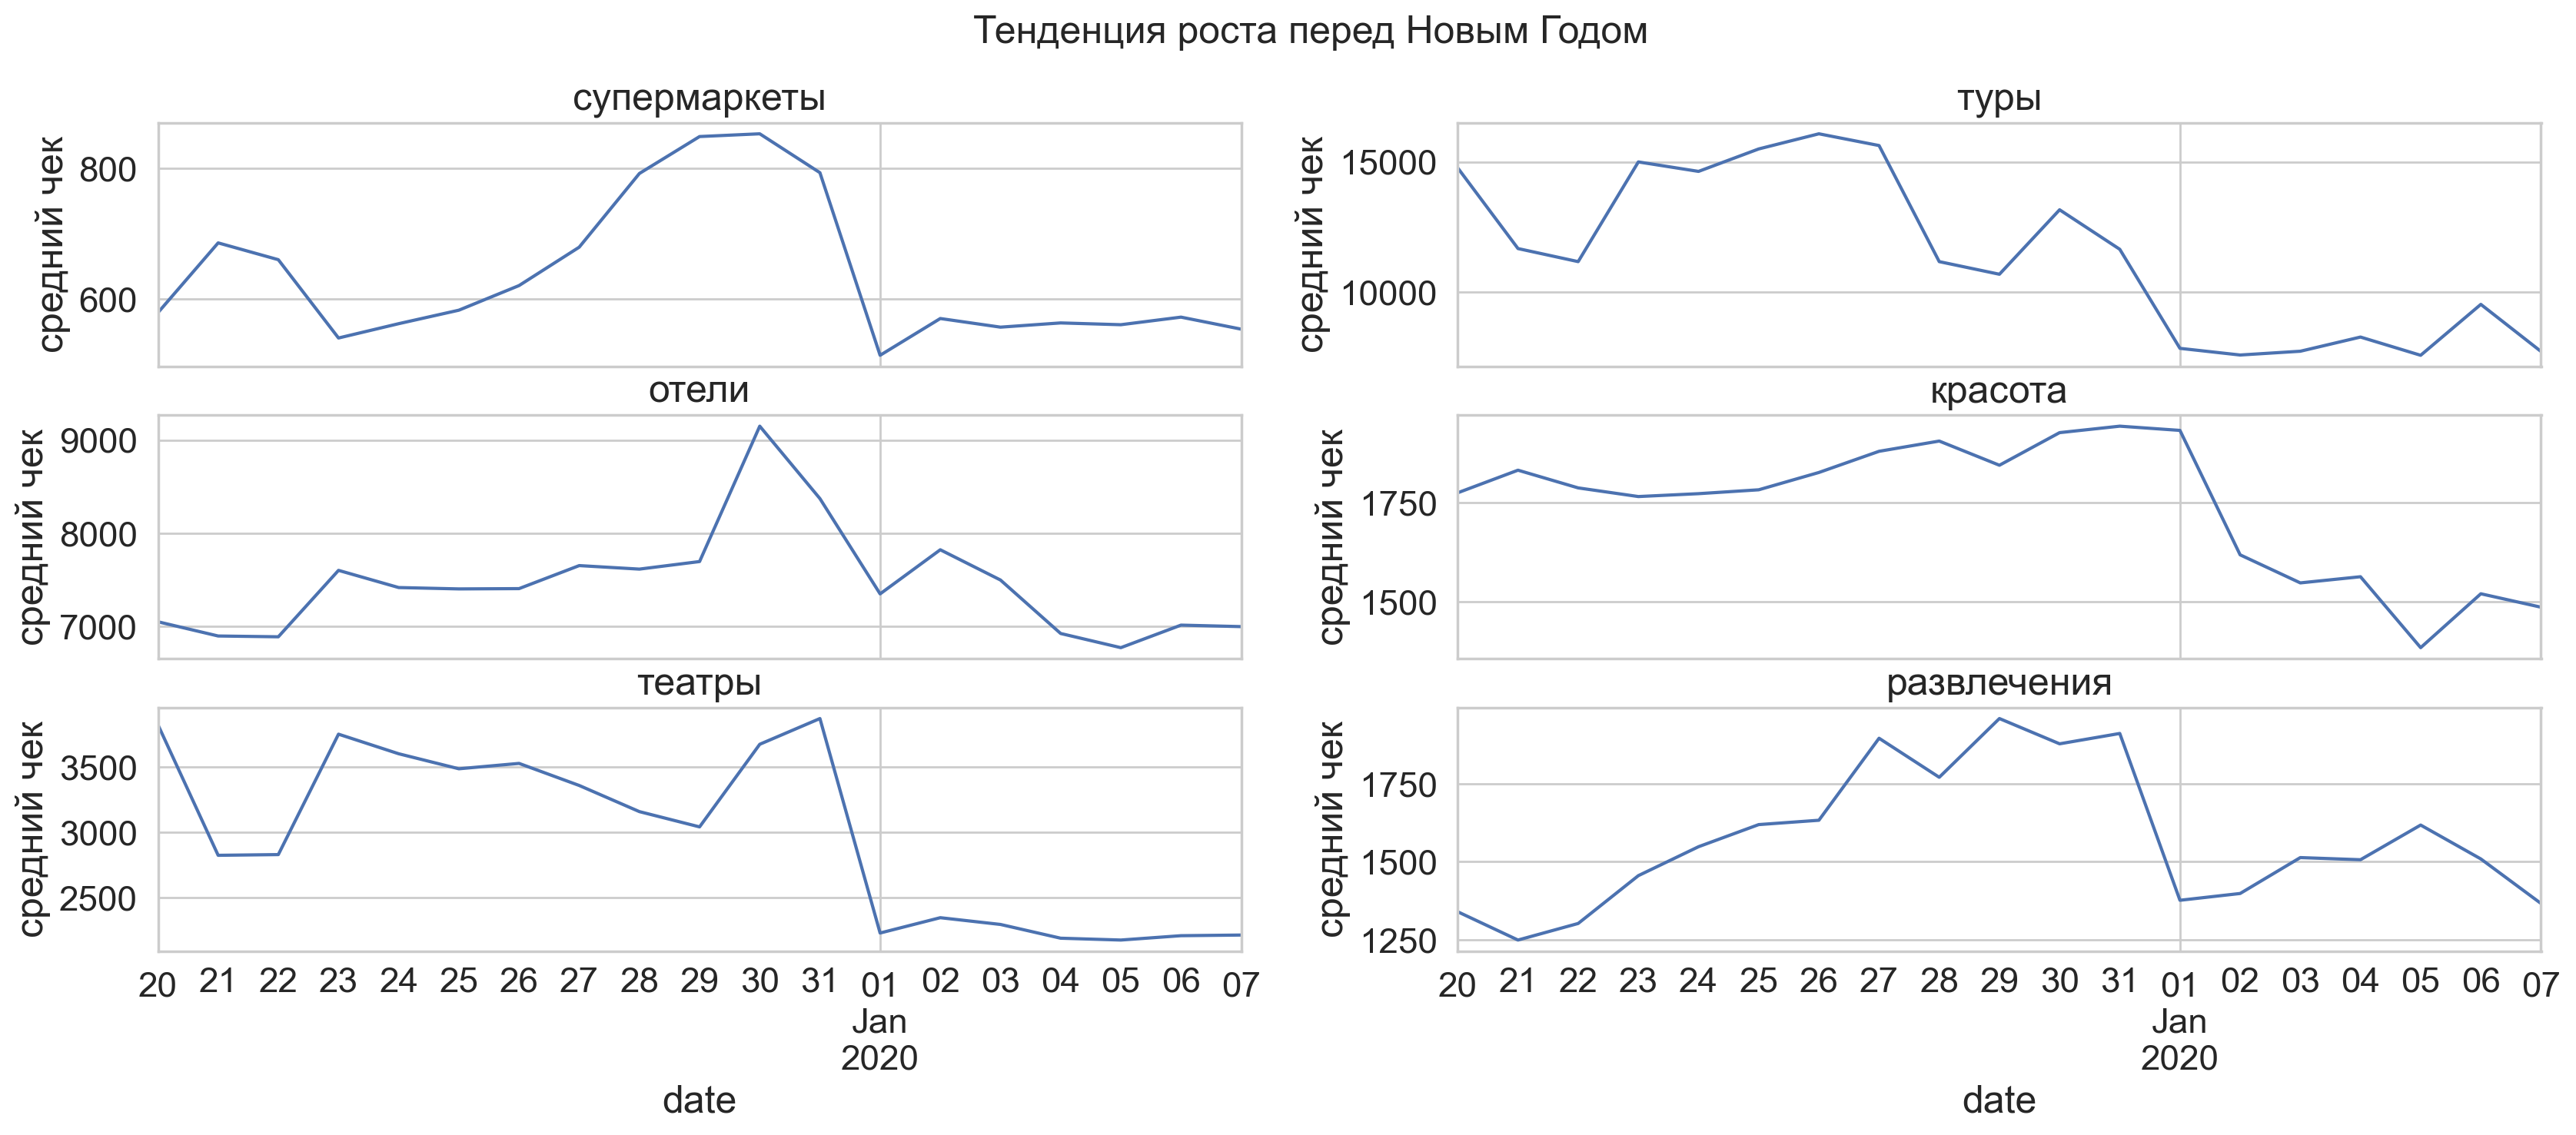

In [39]:
df1 = ny_2020['супермаркеты']
df2 = ny_2020['туры']
df3 = ny_2020['отели']
df4 = ny_2020['красота']
df5 = ny_2020['театры']
df6 = ny_2020['развлечения']
titles_list_1 = ['супермаркеты','туры','отели','красота','театры','развлечения']
df_list_before = [df1,df2, df3, df4, df5, df6]
fig2, axes2 = plt.subplots(3,2, sharex=True)
fig2.suptitle('Тенденция роста перед Новым Годом', fontsize=18)
counter = 0
for i in range(3):
	for j in range(2):
		df_list_before[counter].plot(ax=axes2[i,j],title=titles_list_1[counter], ylabel='средний чек')
		counter+=1

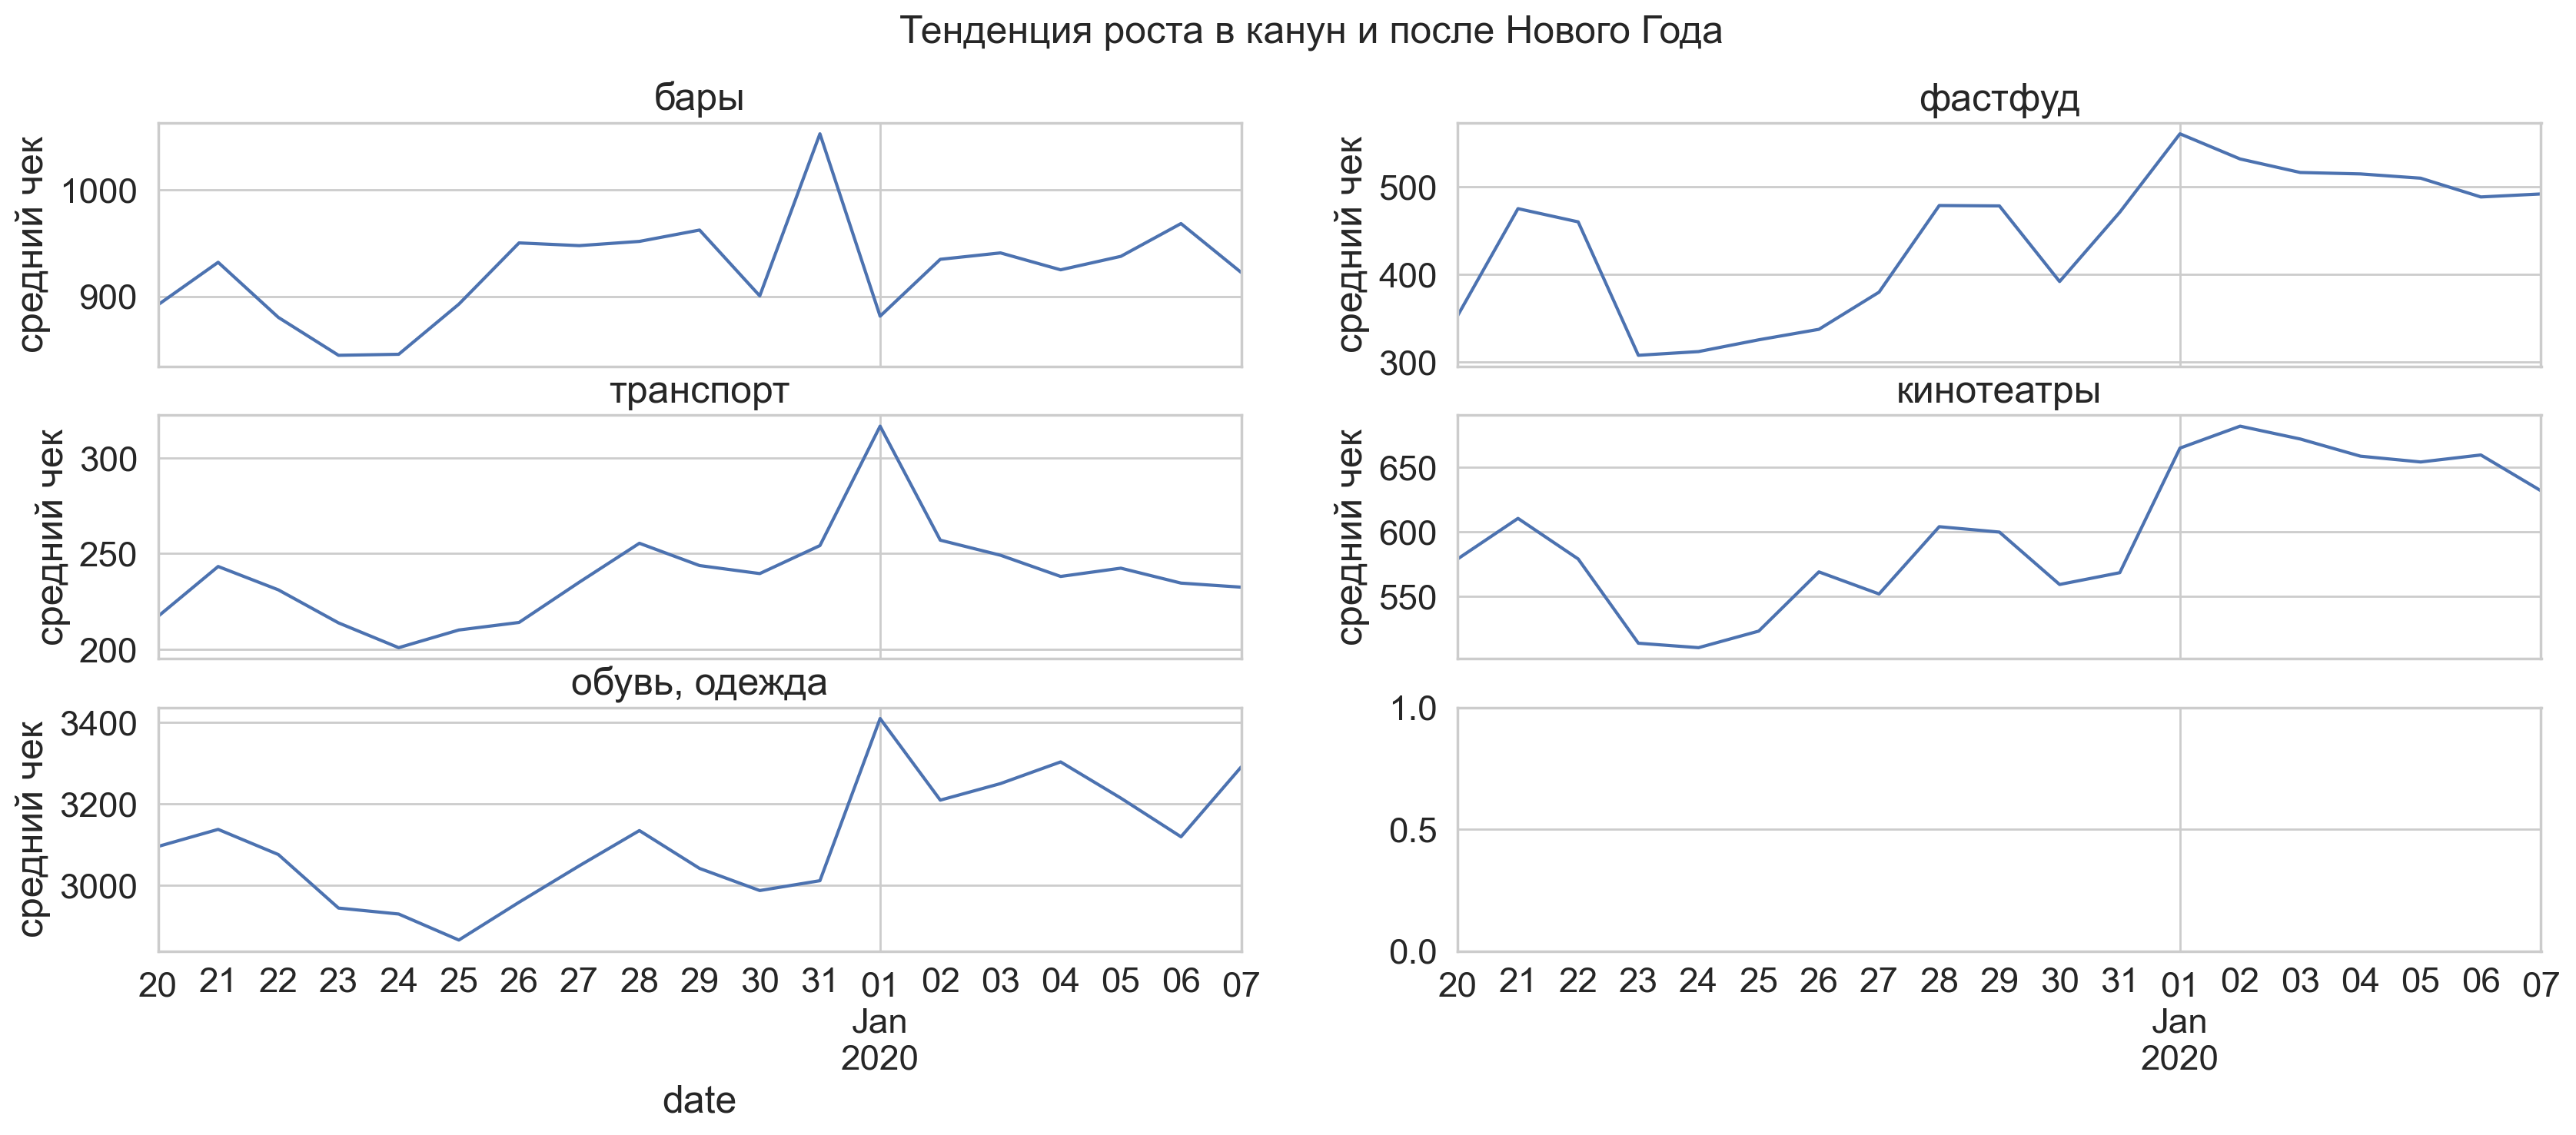

In [23]:
df7 = ny_2020['бары']

df9 = ny_2020['транспорт']

df10 = ny_2020['фастфуд']
df11 = ny_2020['кинотеатры']
df12 = ny_2020['обувь, одежда']

titles_list_2 = ['бары','фастфуд','транспорт','кинотеатры', 'обувь, одежда']
df_list_at_ny = [df7, df10, df9, df11, df12]
fig3, axes3 = plt.subplots(3,2, sharex=True)
fig3.suptitle('Тенденция роста в канун и после Нового Года', fontsize=18)

counter = 0
for i in range(3):
	for j in range(2):
		df_list_at_ny[counter].plot(ax=axes3[i,j],title=titles_list_2[counter], ylabel='средний чек')
		counter+=1
		if counter == len(titles_list_2):
			break

#### Из наиболее наглядного, увеличение среднего чека характерно для следующих категорий:
<u><b>Перед Новым Годом</b></u>:
<ol>
<li>супермаркеты - закупка продуктов перед праздником</li>
<li>туры, отели и фитнес - могут выступать в качестве праздничного подарка</li>
<li>топливо -  видимо люди чаще заливают "полный бак" в предверии праздников</li>
<li>театры, развлечения - появление у людей свободного времени, связанного с предпраздничными днями и выходными</li>
</ol>

<u><b>В канун Нового Года</b></u>:

* бары
* красота - траты на парикмахерские, салоны красоты
* транспорт - траты на такси и общественный транспорт, чтобы провести праздник вместе с родственниками или знакомыми, либо чтобы докупить подарки или что-то недостающее

<u><b>После Нового Года</b></u>:
* фастфуд - возможно это связяно с тем, что люди начинают чаще выходить на улицу, тем самым пользуются быстрым и простым способом перекусить 
* кино, одежда - скорее всего связано с появлением большого количества свободного времени



#### Теперь проверим как растут траты в категории фитнес весной

In [24]:
wastes = df_days.reset_index()\
                .drop(['year'], axis=1)\
                .loc[:,(slice(None),['день','сумма_трат'])]

wastes.columns = wastes.columns.droplevel(1)
wastes.rename(columns={'категория':'date'}, inplace=True)
wastes.query('date>"2021-01-15" and date<"2021-06-07"', inplace=True)
fit_wastes = wastes.set_index('date')['фитнес']

/var/folders/wk/f7xb8jbs2f95g5mv_2cpn6hh0000gn/T/ipykernel_80994/3732724604.py:1: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [25]:
px.line(data_frame=fit_wastes.rolling(4).mean())

#### На графике видны резкие максимумы, которые связаны в основном с ежемесячными платежами
Однако при этом суммарную тенденцию можно назвать спадающей по мере приближения к лету, это может быть связано с тем, что люди теряют надежду привести себя в форму.

## Задача 3
В какие месяцы и в каких категориях продаж происходили наибольшие взлеты и падения? [100]

<span style="color:green">__Открытый вопрос__:</span> от Вас требуется проанализировать данные, сформировать не менее 4 гипотез и проверить их — отвергнуть или подтвердить. Примеры гипотез для проверки предложены в задании #2.

Далее идет проверка на данных -> результат с графиками, отражающими проверку гипотезы + интерпретацию результатов

#### В какие месяцы и в каких категориях продаж происходили наибольшие взлеты и падения?

In [26]:
by_month = df_days.reset_index().loc[:, (slice(None),['день','сумма_трат'])]
by_month.columns = by_month.columns.droplevel(1)
by_month.rename(columns={'категория':'date'}, inplace=True)

by_month['year_month'] = by_month.date.dt.strftime('%Y-%m')
by_month
by_month.head()

category,date,авиабилеты,автосервис,аптеки,бары,"дом, ремонт",доставка еды,другое,ж/д билеты,зоомагазины,...,отели,развлечения,супермаркеты,театры,топливо,транспорт,туры,фастфуд,фитнес,year_month
0,2019-01-01,0.010231,0.000343,0.003922,0.002554,0.005662,0.000109,0.051617,0.003117,0.000108,...,0.011523,0.003426,0.044377,0.002250,0.009562,0.010322,0.001966,0.010080,0.000832,2019-01
1,2019-01-02,0.012811,0.002439,0.008208,0.002381,0.026357,0.000151,0.094138,0.004136,0.000935,...,0.017995,0.005345,0.081902,0.002999,0.017547,0.011084,0.002587,0.017424,0.002228,2019-01
2,2019-01-03,0.013293,0.006182,0.008876,0.002737,0.033407,0.000177,0.114822,0.004039,0.001344,...,0.017453,0.005919,0.088385,0.002710,0.019501,0.009940,0.003230,0.019839,0.002810,2019-01
3,2019-01-04,0.014658,0.008501,0.009292,0.002677,0.036214,0.000181,0.119963,0.003979,0.001372,...,0.014984,0.005863,0.095242,0.002605,0.020506,0.010130,0.003656,0.020612,0.002955,2019-01
4,2019-01-05,0.012856,0.008745,0.009389,0.002896,0.037037,0.000209,0.119032,0.003457,0.001356,...,0.014574,0.005557,0.101247,0.002396,0.021398,0.010110,0.003956,0.020930,0.002814,2019-01


In [27]:
dif_df_by_month = by_month.groupby(['year_month'])\
                .agg(func=lambda x: x.max()-x.min())\
                .reset_index()

dif_df_by_month.drop(['date'],axis=1, inplace=True)
dif_df_by_month.set_index(['year_month'], inplace=True)
dif_df_by_month.head()

category,авиабилеты,автосервис,аптеки,бары,"дом, ремонт",доставка еды,другое,ж/д билеты,зоомагазины,"кафе, рестораны",...,"обувь, одежда",отели,развлечения,супермаркеты,театры,топливо,транспорт,туры,фастфуд,фитнес
year_month,,,,,,,,,,,,,,,,,,,,,
2019-01,0.025233,0.013701,0.008292,0.002316,0.040065,0.000191,0.091849,0.001692,0.001953,0.012912,...,0.040052,0.009252,0.003282,0.092000,0.001308,0.013046,0.005198,0.006965,0.013896,0.006327
2019-02,0.010989,0.006117,0.003305,0.002953,0.021890,0.000123,0.043711,0.001575,0.000532,0.016889,...,0.026238,0.002323,0.002364,0.057376,0.001462,0.004112,0.002970,0.007475,0.008906,0.004649
2019-03,0.032106,0.013226,0.003477,0.002603,0.020603,0.000136,0.066211,0.002497,0.000645,0.021408,...,0.033436,0.004390,0.001956,0.061540,0.004324,0.004779,0.003225,0.009231,0.009802,0.003500
2019-04,0.012237,0.011538,0.004451,0.002486,0.019700,0.000126,0.055221,0.002122,0.000612,0.012843,...,0.027251,0.004523,0.001757,0.061329,0.001619,0.008205,0.002626,0.009863,0.007605,0.003516
2019-05,0.015366,0.010112,0.003982,0.002316,0.022000,0.000127,0.059700,0.002942,0.000759,0.011632,...,0.019280,0.009438,0.002080,0.041511,0.001353,0.008350,0.006300,0.006903,0.007383,0.005085


<AxesSubplot:xlabel='category', ylabel='year_month'>

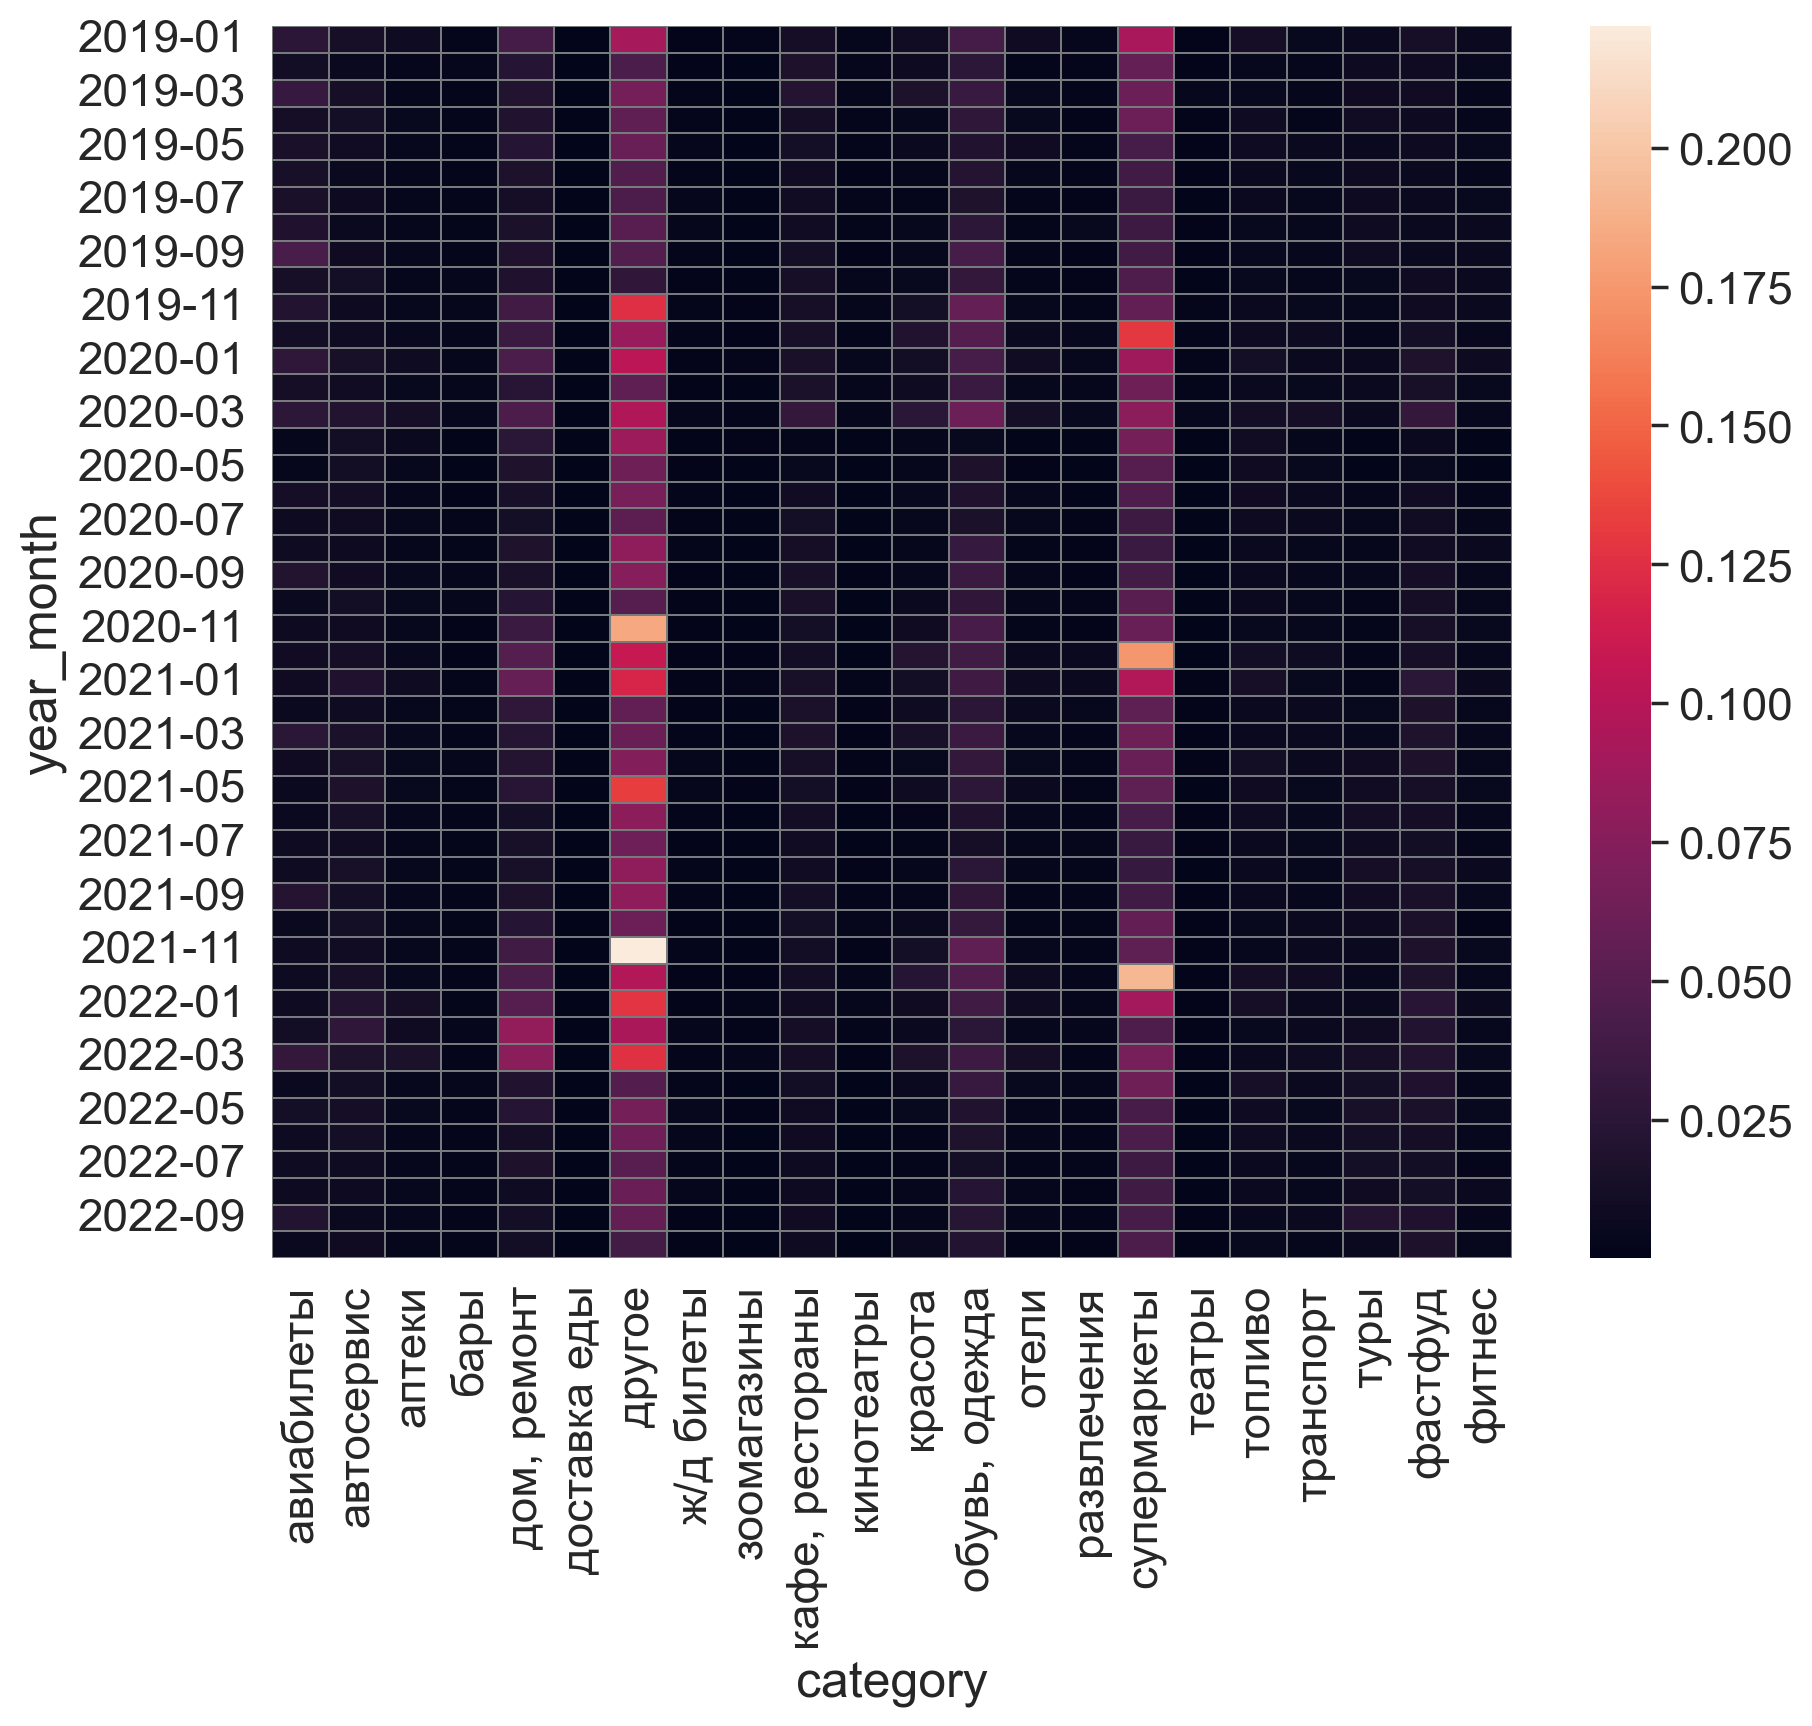

In [47]:
plt.figure(figsize=(10,8))
sns.heatmap(data=dif_df_by_month, linewidths=0.1, linecolor='#777b7b')

> По графику видим, что наибольшие взлеты и падения происходили:
> - в разделах супермаркеты - в декабре, т.е. на новый год
> - обувь, одежда - в марте и ноябре, как раз в момент смены сезона
> - кафе/рестораны - наиболее выделяется март, поскольку к концу месяца появляется хорошая погода, люди гуляют и при этом пользуются услугами ресторанов и кафе


### Предлагается проверить следующие гипотезы:
<ol>
<li><b>Когда в течение года люди чаще заболевают?</b> </li> 
	- Осенью и весной люди заболевают чаще. Для этого рассмотрим траты в аптеках за год 
	
	
<li><b>Как влияют праздники на траты в области красоты</b></li>
	- Наибольший вклад в траты в области красоты вносит 8-е марта

<li><b>Как повлиял коронавирус покупку топлива</b></li>
	- С наступлением коронавируса траты на покупку топлива уменьшились
	
<li><b>Как праздники влияют на покупку ж/д билетов</b></li>
	- В предверии и после праздников количество трат на покупку ж/д билеты увеличивается
</ol>

#### Гипотеза 3.1 
Проверим когда люди чаще заболевают


In [29]:
px.line(data_frame=df_month.loc[:,(slice(None),['день','сумма_трат'])]['аптеки'])

/var/folders/wk/f7xb8jbs2f95g5mv_2cpn6hh0000gn/T/ipykernel_80994/1472668072.py:1: FutureWarning:

The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`



#### Как раз по графику можно определить месяц начала Covid-19, который как раз пришелся на март 2019 года
В течении года наиболее выделсяется октябрь<br>
Таким образом, люди чаще болеют в марте и октябре


#### Гипотеза 3.2
Как влияют праздники на траты в категории красота?

In [30]:
beauty_days = df_days.loc[:,(slice(None),['день','сумма_трат'])].set_index(('категория','день'))['красота']
beauty_days.head()
beauty_days.reset_index()\
			.rename(columns={('категория','день'):'date',
								'сумма_трат':'Траты в области красоты'})\
			.set_index('date')
			

type,Траты в области красоты
date,
2019-01-01,0.001660
2019-01-02,0.005917
2019-01-03,0.007052
2019-01-04,0.008376
2019-01-05,0.008296
...,...
2022-10-27,0.008695
2022-10-28,0.009922
2022-10-29,0.010713


In [31]:
px.line(beauty_days.rolling(3).mean())

#### По графику видна сильная просадка в первые месяцы пандемии
Сильные пики, как и ожидалось, перед праздниками Новый Год и 8-е марта
В свою очередь в районе майских праздников, наоборот, наблюдаются просадки

<a id='hyp3'></a>

#### Гипотеза 3.3
Проверим как уменьшились траты на топливо до/после короновируса



In [33]:
fuel = df_days.loc[:,(slice(None),['день','сумма_трат'])]
fuel.columns = fuel.columns.droplevel(1)
fuel=fuel[['категория','топливо']]\
			.rename(columns={'категория':'дата'}) \
			.set_index('дата')
fuel.head()

category,топливо
дата,
2019-01-01,0.009562
2019-01-02,0.017547
2019-01-03,0.019501
2019-01-04,0.020506
2019-01-05,0.021398


In [34]:
px.line(data_frame=fuel.rolling(30).mean())

#### В конце апреля - начале мая в результате пандемии образовался сильный минимум относительно трат на топливо
Максимумы в августе связаны с поездками на отдых непосредственно на автотранспорте<br>
Причем максимум в августе 2019 года меньше аналогичного в 2020, что может быть связано с закрытием некоторых границ в связи с пандемией

#### Гипотеза 3.4
Как праздники влияют на покупку ж/д билетов



In [36]:
rail_w_transac = df_days.loc[:,(slice(None),['день','количество_транзакций'])]
rail_w_transac.columns = rail_w_transac.columns.droplevel(1)
rail_w_transac=rail_w_transac[['категория','ж/д билеты']]\
			.rename(columns={'категория':'дата'}) \
			.set_index('дата')
rail_w_transac.head()

category,ж/д билеты
дата,
2019-01-01,0.001455
2019-01-02,0.001880
2019-01-03,0.001871
2019-01-04,0.001881
2019-01-05,0.001693


In [37]:
px.line(data_frame=rail_w_transac.rolling(5).mean())

#### По графику видны локальные максимумы около 23 февраля, на майские праздники, а также в летний период
При этом к Новому 2020 году количество покупок билетов меньше чем аналогичное в 2019 и 2021, это может быть связано с тем что в случае короновируса уже были дома и не переезжали
